In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np 
from utils import *
from ADMM import *

In [2]:
data_dir = '../datasets/PEMS0X_data'
# TODO: change here
dataset = 'PEMS04'
data_folder = os.path.join(data_dir, dataset)
data_file = dataset + '.npz'
graph_csv = dataset + '.csv'
# data
traffic_dataset = TrafficDataset(data_folder, data_file, graph_csv)
print(f"data shape: {traffic_dataset.data.shape}, node number: {traffic_dataset.graph_info['n_nodes']}, edge number: {traffic_dataset.graph_info['n_edges']}")

# kNNs and graph construction
k = 4
nearest_nodes, nearest_dists = k_nearest_neighbors(traffic_dataset.graph_info['n_nodes'], traffic_dataset.graph_info['u_edges'], traffic_dataset.graph_info['u_dist'], k)
print(f'nearest nodes: {nearest_nodes.shape}, nearest_dists: {nearest_dists.shape}')

# mixed_graph_from_distance()

x, y = traffic_dataset.get_data(0)
print(f'training shape: x: {x.shape}, y: {y.shape}')

data shape: torch.Size([16992, 307, 1]), node number: 307, edge number: 340
307 nodes, 4 neighbors
nearest nodes: torch.Size([307, 5]), nearest_dists: torch.Size([307, 5])
training shape: x: torch.Size([24, 307, 1]), y: torch.Size([12, 307, 1])


In [3]:
# test primal guess
x, y = x.unsqueeze(0), y.unsqueeze(0)
print(x.dtype, y.dtype)
print(torch.arange(0,12).dtype)
x_init = initial_guess(y, 12, 24)
print(x_init.shape)

torch.float64 torch.float64
torch.int64
torch.Size([1, 24, 307, 1])


torch.Size([24, 10])
torch.Size([24])


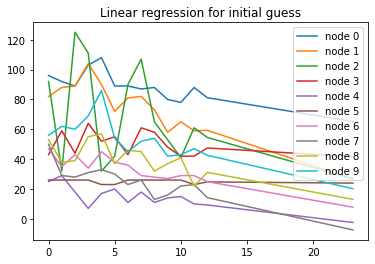

In [4]:
# plot primal guess
from matplotlib import pyplot as plt

x_top = x_init[:,:,0:10].squeeze()
print(x_top.shape)
t = torch.arange(0,24,1)
print(t.shape)
plt.figure()
plt.plot(t, x_top)
plt.legend([f'node {i}' for i in range(10)])
plt.title('Linear regression for initial guess')
plt.show()

In [5]:
# test CG solver with no solution case, but not applied in ADMM since the matrix in LHS function is always positive-definite

A = torch.ones((6, 6))#  + torch.diag_embed(torch.ones(6))
def Ax(x):
    B, T, N, C = x.size()
    x = x.reshape(B, -1, C)
    # print('x',x.reshape(-1), 'Ax', A @ x.reshape(-1))
    return torch.einsum('ij, bjc -> bic', A, x).reshape(B, T, N, C)

def Atx(x):
    B, T, N, C = x.size()
    x = x.reshape(B, -1, C)
    # print('x',x.reshape(-1), 'Ax', A @ x.reshape(-1))
    return torch.einsum('ij, bjc -> bic', A.T, x).reshape(B, T, N, C)

def CG_solver(LHS_func, RHS, x0=None, At_func=None):
    '''
    Solving linear systems LHS_func(x) = RHS, B samples at the same time
    Input:
        x0 in (B, T, N, n_channels)
        LHS_func(x, args) in (B, T, N, n_channels)
        RHS in (B, T, N, n_channels)
    '''
    has_solution = True
    alpha_list = []
    beta_list = []
    if x0 is None:
        x = torch.zeros_like(RHS)
    else:
        x = x0.clone()
    
    r = RHS - LHS_func(x)
    p = r.clone() # in (B, T, N, C)

    r_norm_sq = (r * r).sum([1,2]) # in (B,)
    # print(f'initial error {torch.sqrt(r_norm_sq)}')
    for k in range(100):
        Ap = LHS_func(p)
        # print('p', p.squeeze(), 'Ap', Ap.squeeze())
        alpha = r_norm_sq / (p * Ap).sum([1,2]) # in (B,)
        if alpha.max() > 1e6:
            print(f'no solution, Ap = {alpha.max()}, compute least square solution')
            print(f'at this time x = {x.squeeze()}, real error = {torch.abs(LHS_func(x) - RHS).max():.4f}')
            has_solution = False
            break
        alpha_list.append(alpha)
        x = x + alpha[:, None, None, :] * p
        r = r - alpha[:, None, None, :] * Ap

        r_norm_new_sq = (r * r).sum([1,2]) # in (B,)
        beta = r_norm_new_sq / r_norm_sq
        beta_list.append(beta)

        print(f"CG iteration {k}: real error {torch.abs(LHS_func(x) - RHS).max():.4f}, total max error {torch.sqrt(r_norm_new_sq).max():.4g}, alpha in ({alpha.min():.4g}, {alpha.max():.4g}), beta in ({beta.min():.4g}, {beta.max():.4g})")

        if torch.sqrt(r_norm_new_sq).max() < 1e-8:
            print(f'{k+1} CG iterations')
            return x, k + 1, torch.Tensor(alpha_list), torch.Tensor(beta_list) # iterations
        

        p = r + beta[:, None, None, :] * p
        r_norm_sq = r_norm_new_sq
    
    if not has_solution:
        def AtA_func(x):
            return At_func(LHS_func(x))
        return CG_solver(AtA_func, At_func(RHS), x0)
        # return None

    return x, 100, alpha_list, beta_list

RHS = torch.Tensor([[2,2,2,3,3,3]]).reshape(1, 2, 3, 1).to(torch.float)
x, iters, alphas, betas = CG_solver(Ax, RHS, RHS, At_func=Atx)
print(x)



CG iteration 0: real error 0.5200, total max error 1.226, alpha in (0.1669, 0.1669), beta in (0.0016, 0.0016)
no solution, Ap = 183545118720.0, compute least square solution
at this time x = tensor([[-0.1701, -0.1701, -0.1701],
        [ 0.9968,  0.9968,  0.9968]]), real error = 0.5200
CG iteration 0: real error 0.0000, total max error 0, alpha in (0.02778, 0.02778), beta in (0, 0)
1 CG iterations
tensor([[[[-0.0833],
          [-0.0833],
          [-0.0833]],

         [[ 0.9167],
          [ 0.9167],
          [ 0.9167]]]])


In [6]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init,
    'rho_u': rho_init,
    'rho_d': rho_init,
    'mu_u': 3,
    'mu_d1':3,
    'mu_d2': 3
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=20,
                            d_sigma=20,
                            )

rho_init: 3.5765439556458225
307 nodes, 4 neighbors
Undirected graph: sigma = 20, nearest_dist in (3.2000, 2895.6001)
Directed Graph: sigma = 20, nearest_dist in (3.2000, 2895.6001)
u_ew, d_ew shape torch.Size([24, 307, 4]) torch.Size([23, 307, 5])


ADMM iters 0: x_CG_iters 15, zu_CG_iters 26, zd_CG_iters 33, pri_err = [4316, 64.22, 565.9], dual_err = [4317, 64.25, 565.9]
ADMM iters 1: x_CG_iters 22, zu_CG_iters 24, zd_CG_iters 32, pri_err = [457.3, 31.5, 200.5], dual_err = [285, 613.4, 3775]
ADMM iters 2: x_CG_iters 21, zu_CG_iters 25, zd_CG_iters 32, pri_err = [1017, 30.8, 134.4], dual_err = [560.3, 310.4, 1764]
ADMM iters 3: x_CG_iters 21, zu_CG_iters 25, zd_CG_iters 31, pri_err = [1055, 33.16, 120.4], dual_err = [570.5, 154.6, 611.7]
ADMM iters 4: x_CG_iters 20, zu_CG_iters 24, zd_CG_iters 30, pri_err = [711.5, 21.09, 105.5], dual_err = [402.1, 78.37, 217.7]
ADMM iters 5: x_CG_iters 20, zu_CG_iters 24, zd_CG_iters 30, pri_err = [366.8, 12.71, 85.03], dual_err = [240.2, 50.23, 240.7]
ADMM iters 6: x_CG_iters 20, zu_CG_iters 23, zd_CG_iters 29, pri_err = [153.1, 9.937, 64.45], dual_err = [141.4, 40.02, 203.3]
ADMM iters 7: x_CG_iters 19, zu_CG_iters 23, zd_CG_iters 29, pri_err = [77.65, 8.735, 45.9], dual_err = [98.26, 32.96, 13

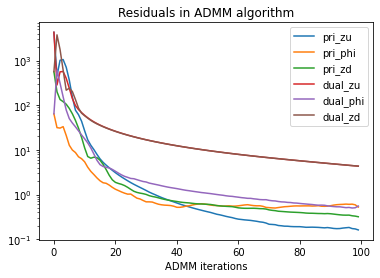

In [7]:
# test ADMM algorithm
x_pred = admm_block.combined_loop(y)
admm_block.plot_residual('ADMM_algorithm.png')

ADMM iters 0: x_CG_iters 2, zu_CG_iters 26, zd_CG_iters 33, pri_err = [4316, 565.9], dual_err = [4317, 565.9]
ADMM iters 1: x_CG_iters 2, zu_CG_iters 25, zd_CG_iters 33, pri_err = [507.4, 238.7], dual_err = [344.7, 3783]
ADMM iters 2: x_CG_iters 2, zu_CG_iters 25, zd_CG_iters 32, pri_err = [1016, 121.3], dual_err = [559.2, 1762]
ADMM iters 3: x_CG_iters 2, zu_CG_iters 25, zd_CG_iters 30, pri_err = [1048, 73.61], dual_err = [564.4, 607.5]
ADMM iters 4: x_CG_iters 2, zu_CG_iters 24, zd_CG_iters 29, pri_err = [704.4, 44.6], dual_err = [397.7, 216.3]
ADMM iters 5: x_CG_iters 2, zu_CG_iters 24, zd_CG_iters 29, pri_err = [362.1, 26.13], dual_err = [238.3, 240.4]
ADMM iters 6: x_CG_iters 2, zu_CG_iters 23, zd_CG_iters 29, pri_err = [151, 15.77], dual_err = [141, 202.3]
ADMM iters 7: x_CG_iters 2, zu_CG_iters 23, zd_CG_iters 28, pri_err = [76.83, 10.45], dual_err = [98.16, 133.6]
ADMM iters 8: x_CG_iters 2, zu_CG_iters 23, zd_CG_iters 28, pri_err = [60.13, 7.602], dual_err = [79.65, 85.63]
ADM

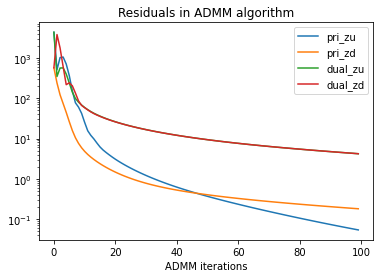

In [8]:
admm_block.init_iterations('DGTV')
x_pred = admm_block.combined_loop(y)
admm_block.plot_residual('ADMM_algorithm_woDGTV.png')

rho_init: 3.5765439556458225
307 nodes, 4 neighbors
Undirected graph: sigma = 50, nearest_dist in (3.2000, 2895.6001)
Directed Graph: sigma = 50, nearest_dist in (3.2000, 2895.6001)
u_ew, d_ew shape torch.Size([24, 307, 4]) torch.Size([23, 307, 5])
ADMM iters 0: x_CG_iters 14, zu_CG_iters 11, zd_CG_iters 16, pri_err = [1141, 21.9, 277.2], dual_err = [1141, 21.91, 277.2]
ADMM iters 1: x_CG_iters 20, zu_CG_iters 10, zd_CG_iters 16, pri_err = [39.76, 6.518, 59.06], dual_err = [154.4, 309.2, 1275]
ADMM iters 2: x_CG_iters 19, zu_CG_iters 11, zd_CG_iters 15, pri_err = [127.3, 5.121, 22.69], dual_err = [466.2, 154, 547.9]
ADMM iters 3: x_CG_iters 19, zu_CG_iters 11, zd_CG_iters 15, pri_err = [114.3, 5.22, 31.25], dual_err = [422.6, 112.7, 410]
ADMM iters 4: x_CG_iters 19, zu_CG_iters 11, zd_CG_iters 15, pri_err = [94.39, 4.966, 33.26], dual_err = [358.4, 87.98, 341.6]
ADMM iters 5: x_CG_iters 19, zu_CG_iters 11, zd_CG_iters 15, pri_err = [77.46, 4.692, 30.47], dual_err = [303.8, 69.87, 290.3

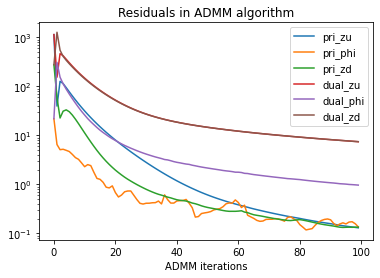

In [12]:
import math
rho_init = math.sqrt(traffic_dataset.graph_info['n_nodes'] / 24)
mu_init = 1
print('rho_init:', rho_init)
ADMM_info = {
    'rho': rho_init * 2,
    'rho_u': rho_init * 3,
    'rho_d': rho_init * 2,
    'mu_u': mu_init,
    'mu_d1':mu_init * 2,
    'mu_d2': mu_init
}
admm_block = ADMM_algorithm(traffic_dataset.graph_info,
                            ADMM_info,
                            use_kNN=True,
                            k=4,
                            u_sigma=50,
                            d_sigma=50,
                            )
x_pred = admm_block.combined_loop(y)
admm_block.plot_residual('ADMM_algorithm.png')

In [14]:
print(admm_block.alpha_x)

[tensor([0.1053, 0.0719, 0.0692, 0.0593, 0.0610, 0.0638, 0.0695, 0.0596, 0.0621,
        0.0662, 0.0627, 0.0604, 0.0591, 0.0648]), tensor([0.0986, 0.0503, 0.0709, 0.0640, 0.0649, 0.0617, 0.0597, 0.0648, 0.0654,
        0.0639, 0.0647, 0.0636, 0.0647, 0.0639, 0.0617, 0.0617, 0.0671, 0.0656,
        0.0619, 0.0640]), tensor([0.0955, 0.0504, 0.0675, 0.0665, 0.0628, 0.0629, 0.0595, 0.0640, 0.0663,
        0.0639, 0.0644, 0.0636, 0.0645, 0.0637, 0.0623, 0.0616, 0.0668, 0.0664,
        0.0616]), tensor([0.0963, 0.0502, 0.0676, 0.0660, 0.0629, 0.0631, 0.0595, 0.0640, 0.0664,
        0.0641, 0.0641, 0.0632, 0.0644, 0.0639, 0.0625, 0.0616, 0.0667, 0.0664,
        0.0617]), tensor([0.0980, 0.0497, 0.0682, 0.0654, 0.0630, 0.0631, 0.0595, 0.0640, 0.0665,
        0.0643, 0.0638, 0.0628, 0.0643, 0.0640, 0.0627, 0.0617, 0.0667, 0.0662,
        0.0617]), tensor([0.0996, 0.0493, 0.0686, 0.0650, 0.0630, 0.0631, 0.0596, 0.0641, 0.0667,
        0.0643, 0.0634, 0.0626, 0.0642, 0.0642, 0.0629, 0.0618, 0.066